# Experiment 5.2 Gender classification with unknown confounding

In [1]:
import data_handler
import configs
import train
import pandas as pd
import matplotlib.pyplot as plt
SEED = 7

### CelebA handcrafted datasets with confounding

In [2]:
config = configs.celebA_experiment()
train_ds, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(config.prop_glasses, config.train_size, config.test_size)

In [3]:
print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)

Train set size:  20000
Distinct IDs that occur more than once:  4464
Mean occurrences of IDs:  2.7789356676392942
Max occurrences of IDs:  27


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses     0     1
Male                  
0           40.0  10.0
1           10.0  40.0


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 1385


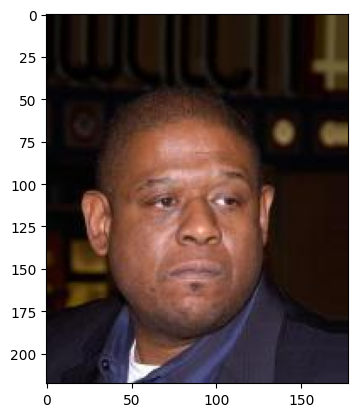

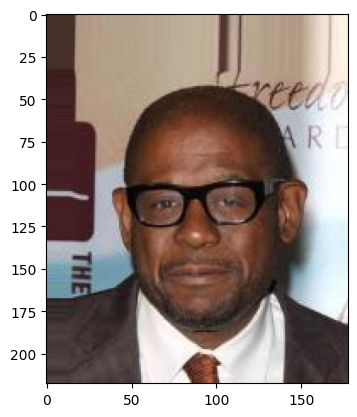

In [59]:
ID = ids_with_and_without_glasses[(ids_with_and_without_glasses[0] == 1) & (ids_with_and_without_glasses[1] == 1)].sample(1).index[0]
images = train_ds[train_ds['ID'] == ID]['image_id'].values

for img in images:
    plt.imshow(plt.imread(f'{img_dir}/{img}'))
    plt.show()

In [4]:
train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

## Pooled estimator

In [8]:
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.learning_rate = 0.1
config.batch_size = 240
state_pooled = train.train_and_evaluate(config, workdir=f"models_celebA_confoung/pooled_classif", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 214565.7344, train_accuracy: 49.38, test1_accuracy: 49.18, test2_accuracy: 49.08, core_penalty: 76881567744.0000
INFO:absl:epoch: 2, train_loss: 147.9192, train_accuracy: 52.44, test1_accuracy: 51.85, test2_accuracy: 50.33, core_penalty: 591.0595
INFO:absl:epoch: 3, train_loss: 104.5261, train_accuracy: 57.35, test1_accuracy: 51.23, test2_accuracy: 50.83, core_penalty: 68.1194
INFO:absl:epoch: 4, train_loss: 99.4280, train_accuracy: 57.35, test1_accuracy: 64.65, test2_accuracy: 51.92, core_penalty: 16.3272
INFO:absl:epoch: 5, train_loss: 94.0521, train_accuracy: 57.63, test1_accuracy: 61.70, test2_accuracy: 50.92, core_penalty: 3.7650
INFO:absl:epoch: 6, train_loss: 91.6341, train_accuracy: 57.34, test1_accuracy: 54.13, test2_accuracy: 50.00, core_penalty: 3.4394
INFO:absl:epoch: 7, train_loss: 87.9382, train_accuracy: 59.53, test1_accuracy: 65.95, test2_accuracy: 51.25, core_penalty: 1.7833
INFO:absl:epoch: 8, train_loss: 85.7330, train_accuracy: 59.33,

In [ ]:
config = configs.celebA_experiment()
config.lambda_core = 2.0
config.learning_rate = 0.1
config.batch_size = 240
config.num_epochs = 100
state_pooled = train.train_and_evaluate(config, workdir=f"models_celebA_confoung/core_classif_100", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

In [11]:
config = configs.celebA_experiment()
config.lambda_core = 2.0
config.learning_rate = 0.1
config.batch_size = 240
state_pooled = train.train_and_evaluate(config, workdir=f"models_celebA_confoung/core_classif", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 4569211.5000, train_accuracy: 49.09, test1_accuracy: 44.15, test2_accuracy: 50.75, core_penalty: 2283777.5000
INFO:absl:epoch: 2, train_loss: 449.2817, train_accuracy: 47.45, test1_accuracy: 44.13, test2_accuracy: 52.08, core_penalty: 170.8681
INFO:absl:epoch: 3, train_loss: 232.7002, train_accuracy: 48.33, test1_accuracy: 44.30, test2_accuracy: 56.08, core_penalty: 70.2680
INFO:absl:epoch: 4, train_loss: 155.2355, train_accuracy: 48.82, test1_accuracy: 46.50, test2_accuracy: 53.08, core_penalty: 33.5806
INFO:absl:epoch: 5, train_loss: 129.0604, train_accuracy: 50.03, test1_accuracy: 47.38, test2_accuracy: 52.42, core_penalty: 21.3175
INFO:absl:epoch: 6, train_loss: 112.0597, train_accuracy: 51.35, test1_accuracy: 52.20, test2_accuracy: 56.92, core_penalty: 13.6805
INFO:absl:epoch: 7, train_loss: 107.3523, train_accuracy: 51.28, test1_accuracy: 47.93, test2_accuracy: 58.58, core_penalty: 11.7689
INFO:absl:epoch: 8, train_loss: 104.7546, train_accuracy: 5

### More clever dataset creation

In [140]:
train_ds, validation_ds, test_ds, img_dir = data_handler.load_original_celebA()

# Combine all datasets and shuffle
all_ds = pd.concat([train_ds, validation_ds, test_ds])
all_ds = all_ds.sample(frac=1, random_state=SEED).reset_index(drop=True)  # Permute dataset

# IDs with at least one image with and without glasses
grouped = all_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("Number of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 3241
These IDs encompass a total of 70928 images
Mean number of images with glasses per ID: 3.3980253008330763
Mean number of images without glasses per ID: 18.486578216599813


In [135]:
# sample 500 distinct IDs from ids_with_and_without_glasses
sampled_ids = ids_with_and_without_glasses.sample(500, random_state=SEED).index
ds_sampled = all_ds[all_ds['ID'].isin(sampled_ids)]

grouped = ds_sampled.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("Number of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 500
These IDs encompass a total of 11087 images
Mean number of images with glasses per ID: 3.364
Mean number of images without glasses per ID: 18.81
